# VideoMAE 2D Training Notebook

This notebook trains a 2D MAE model using an HDF5 dataset:
- Load an HDF5 file from a path
- Split trials into train/val using `split_data`
- Create datasets via `create_dataset('vsd_mae', ...)` and DataLoaders
- Build a 2D MAE (ResNet18 backbone + lightweight decoder)
- Train and log metrics to TensorBoard



In [ ]:
# Imports and configuration
import os
import torch
from torch.utils.data import DataLoader

from src.data.dataset_factory import create_dataset
from src.data.split_data import split_data
from src.models.backbone.mae_backbone_2d import MAEResNet18Backbone
from src.models.heads.mae_decoder_2d import MAEDecoder2D
from src.models.systems.mae_system import MAESystem
from src.utils.logger import TBLogger, set_seed

# --- User config ---
HDF5_PATH = r"G:\My Drive\HDF5_DATA_AFTER_PREPROCESSING2\vsd_video_data.hdf5"
LOG_DIR = "logs"
CKPT_DIR = "checkpoints"
SEED = 42

# Data params
CLIP_LENGTH = 1           # 1 -> 2D (single frame); >1 creates clips but MAE2D squeezes T=1
BATCH_SIZE = 8
NUM_WORKERS = 2
SPLIT_RATIO = 0.8

# Masking params for dataset
MASK_RATIO = 0.75
PATCH_SIZE = (1, 16, 16)  # (T, H, W); T=1 for 2D

# Training params
EPOCHS = 5
LR = 1e-4
WEIGHT_DECAY = 0.05

# Setup
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)
set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cpu


Visualizing random sample 5238 from dataset
Video tensor shape: torch.Size([1, 10, 100, 100])
Frame range: 131 to 140

📊 Plotting frames sequence...


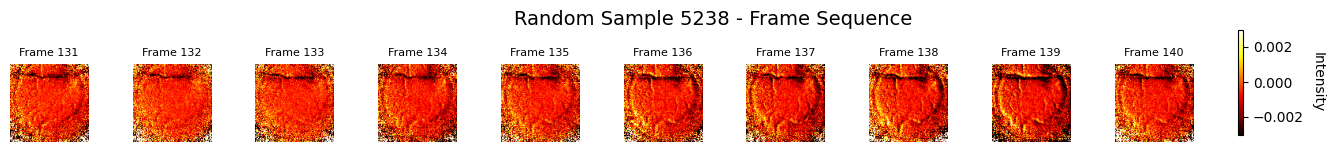


✅ Visualization complete!


In [2]:
# Visualize a random sample before splitting
import random
import matplotlib.pyplot as plt
from src.utils.visualization import plot_frames_sequence, plot_spatial_dynamics

# Create a temporary dataset to sample from (before split)
temp_ds = create_dataset(
    "vsd_video",  # Use base dataset, not masked version for visualization
    hdf5_path=HDF5_PATH,
    clip_length=CLIP_LENGTH,
    normalize=False,
)

# Get a random sample
random_idx = random.randint(0, len(temp_ds) - 1)
sample = temp_ds[random_idx]
video_tensor = sample["video"]  # (C, T, H, W)
start_frame = sample.get("start_frame", 0)
end_frame = sample.get("end_frame", 0)

print(f"Visualizing random sample {random_idx} from dataset")
print(f"Video tensor shape: {video_tensor.shape}")
print(f"Frame range: {start_frame} to {end_frame}")

# Prepare real frame range for visualization
real_frame_range = (int(start_frame), int(end_frame)) if start_frame is not None and end_frame is not None else None

# Plot frames sequence
print("\n📊 Plotting frames sequence...")
fig1 = plot_frames_sequence(
    video_tensor=video_tensor,
    start_frame=0,
    end_frame=None,  # Use all frames
    clipping=(-0.003, 0.003),
    cols=10,
    title=f"Random Sample {random_idx} - Frame Sequence",
    show_plot=True,
    real_frame_range=real_frame_range
)

print("\n✅ Visualization complete!")


In [3]:
# Split data into train/val by trials
train_trials, val_trials, index_entries = split_data(HDF5_PATH, split_ratio=SPLIT_RATIO, random_seed=SEED)
print(f"Train trials: {len(train_trials)} | Val trials: {len(val_trials)}")

Global data split summary:
  Total trials: 212
  Train trials: 169 (79.7%)
  Val trials: 43 (20.3%)
Train trials: 169 | Val trials: 43


In [4]:
# Build datasets and dataloaders
train_ds = create_dataset(
    "vsd_mae",
    hdf5_path=HDF5_PATH,
    clip_length=CLIP_LENGTH,
    frame_start=20,
    frame_end=100,
    trial_indices=train_trials,
    index_entries=index_entries,
    normalize=False,
    mask_ratio=MASK_RATIO,
    patch_size=PATCH_SIZE,
)

val_ds = create_dataset(
    "vsd_mae",
    hdf5_path=HDF5_PATH,
    clip_length=CLIP_LENGTH,
    frame_start=20,
    frame_end=100,
    trial_indices=val_trials,
    index_entries=index_entries,
    normalize=False,
    mask_ratio=MASK_RATIO,
    patch_size=PATCH_SIZE,
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")


Train samples: 1352 | Val samples: 344


In [ ]:
# from src.models.backbone.mae_backbone_3d import MAER3D18Backbone
# from src.models.heads.mae_decoder_3d import MAEDecoder3D

# Build MAE 2D model and optimizer
encoder = MAEResNet18Backbone(pretrained=False, in_channels=1)
decoder = MAEDecoder2D(in_channels=encoder.feature_dim, out_channels=1, hidden_dim=256)

config = {
    "training": {"lr": LR, "weight_decay": WEIGHT_DECAY},
    "loss": {"normalize": True},
}

model = MAESystem(encoder=encoder, decoder=decoder, config=config).to(DEVICE)
optimizer = model.get_optimizer()
logger = TBLogger(log_dir=LOG_DIR)

print(model.__class__.__name__, "built.")


MAESystem built.


In [6]:
# Train using generic Trainer (supports MAE 2D/3D and DINO)
from src.training.trainer import Trainer
from src.utils.logger import TBLogger

trainer_cfg = {
    "epochs": EPOCHS,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "log_dir": LOG_DIR,
    "ckpt_dir": CKPT_DIR,
}
logger = TBLogger(log_dir=LOG_DIR)
trainer = Trainer(model=model, logger=logger, cfg=trainer_cfg, device=DEVICE)
trainer.fit(train_loader, val_loader)



c:\Users\itiel\OneDrive\Desktop\VSD_foundation_model\src\training\trainer.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
c:\Users\itiel\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/5:   0%|          | 0/169 [00:00<?, ?it/s]c:\Users\itiel\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\itiel\OneDrive\Desktop\VSD_foundation_model\src\training\trainer.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\itiel\AppData\Lo

KeyboardInterrupt: 

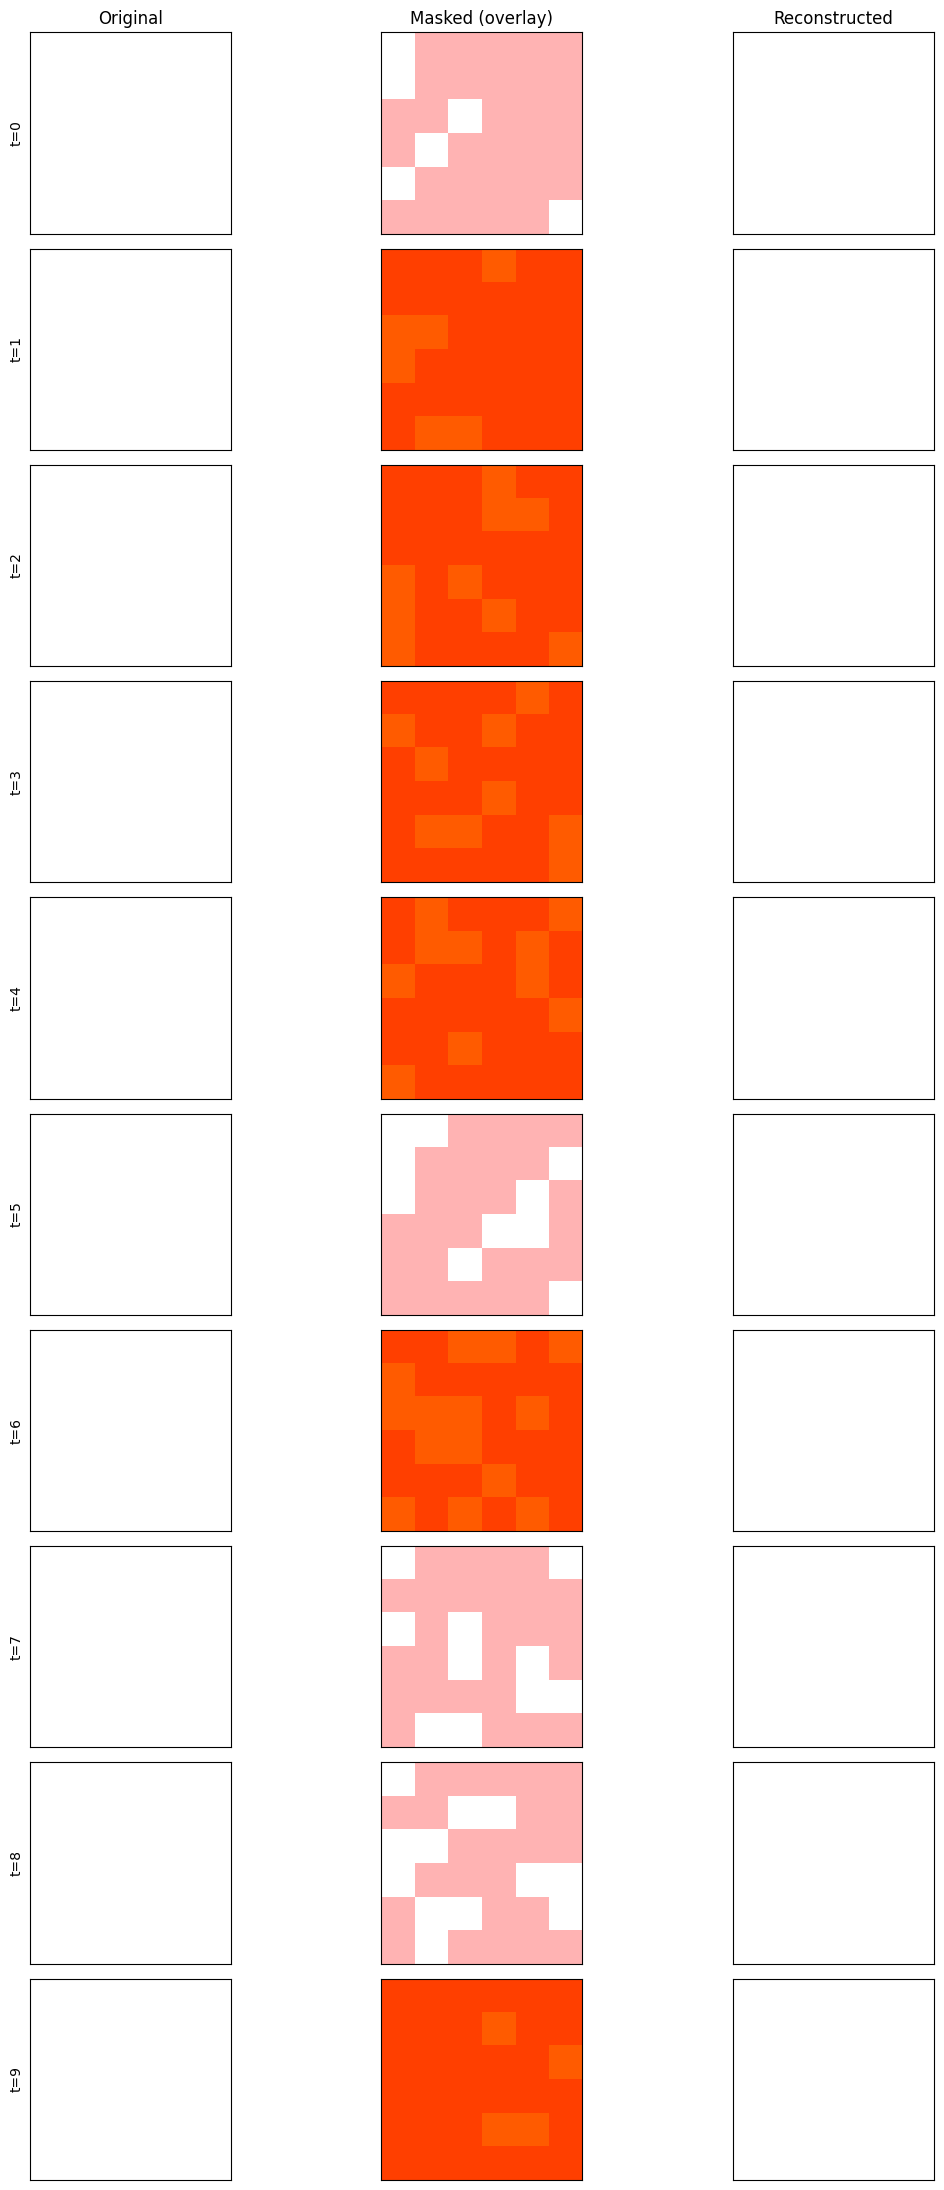

✅ Sequence visualization complete (rows=time, cols=[orig, masked+overlay, recon]).


In [ ]:
# Sequence visualization: plot Original, Masked(+overlay), Reconstructed vertically over time
import numpy as np
import torch.nn.functional as F

# Define a minimal version
def get_reconstruction(model, batch):
    model.eval()
    with torch.no_grad():
        video_masked = batch["video_masked"]
        video_target = batch["video_target"]
        mask = batch["mask"]
        is_2d = False
        if len(video_target.shape) == 5 and video_target.shape[2] == 1:
            is_2d = True
            video_masked = video_masked.squeeze(2)
            video_target = video_target.squeeze(2)
            if len(mask.shape) == 5:
                mask = mask.squeeze(2)
            if len(mask.shape) == 4 and mask.shape[1] == 1:
                H, W = video_target.shape[2], video_target.shape[3]
                mask = F.interpolate(mask, size=(H, W), mode='nearest')
        features = model.encoder(video_masked)
        if is_2d or len(video_target.shape) == 4:
            target_size = (video_target.shape[2], video_target.shape[3])
            reconstruction = model.decoder(features, target_size=target_size)
        else:
            target_size = (video_target.shape[2], video_target.shape[3], video_target.shape[4])
            reconstruction = model.decoder(features, target_size=target_size)
            if len(mask.shape) == 5 and mask.shape[1] == 1:
                T, H, W = video_target.shape[2], video_target.shape[3], video_target.shape[4]
                mask = F.interpolate(mask, size=(T, H, W), mode='nearest')
        return reconstruction, mask, video_target, video_masked

# Fetch a validation batch and reconstruct
model.eval()
val_sample = next(iter(val_loader))
val_sample = {k: v.to(DEVICE) for k, v in val_sample.items()}
reconstruction, mask, original, masked = get_reconstruction(model, val_sample)

# Select first item in batch
b = 0
vmin, vmax = -0.003, 0.003

# Determine dimensionality
# 2D: (C,H,W); 3D: (C,T,H,W)
if original.ndim == 4:  # (B,C,H,W)
    # Single frame (2D)
    T = 1
    orig_frames = original[b, 0][None]      # (1,H,W)
    masked_frames = masked[b, 0][None]
    mask_frames = mask[b, 0]
    if mask_frames.ndim == 2:
        mask_frames = mask_frames[None]     # (1,H,W)
    recon_frames = reconstruction[b, 0][None]
else:
    # Video (3D time): (B,C,T,H,W)
    T = original.shape[2]
    orig_frames = original[b, 0].cpu()          # (T,H,W)
    masked_frames = masked[b, 0].cpu()          # (T,H,W)
    recon_frames = reconstruction[b, 0].cpu()   # (T,H,W)
    mask_frames = mask[b, 0].cpu()              # (T,H,W) after model fix

# Limit number of frames for display
max_rows = 12
rows = min(T, max_rows)
fig, axes = plt.subplots(rows, 3, figsize=(12, 2.2*rows))
if rows == 1:
    axes = np.array([axes])

for t in range(rows):
    # Original
    axes[t, 0].imshow(orig_frames[t].cpu().numpy() if torch.is_tensor(orig_frames[t]) else orig_frames[t], cmap='hot', vmin=vmin, vmax=vmax)
    axes[t, 0].set_ylabel(f"t={t}")
    axes[t, 0].set_xticks([]); axes[t, 0].set_yticks([])
    if t == 0:
        axes[t, 0].set_title('Original')

    # Masked + overlay
    im = axes[t, 1].imshow(masked_frames[t].cpu().numpy() if torch.is_tensor(masked_frames[t]) else masked_frames[t], cmap='hot', vmin=vmin, vmax=vmax)
    m = mask_frames[t].cpu().numpy() if torch.is_tensor(mask_frames[t]) else mask_frames[t]
    overlay = np.zeros((m.shape[0], m.shape[1], 4), dtype=np.float32)
    overlay[..., 0] = 1.0
    overlay[..., 3] = 0.3 * (1.0 - m)  # red where masked
    axes[t, 1].imshow(overlay)
    axes[t, 1].set_xticks([]); axes[t, 1].set_yticks([])
    if t == 0:
        axes[t, 1].set_title('Masked (overlay)')

    # Reconstructed
    axes[t, 2].imshow(recon_frames[t].cpu().numpy() if torch.is_tensor(recon_frames[t]) else recon_frames[t], cmap='hot', vmin=vmin, vmax=vmax)
    axes[t, 2].set_xticks([]); axes[t, 2].set_yticks([])
    if t == 0:
        axes[t, 2].set_title('Reconstructed')

plt.tight_layout()
plt.show()
print("✅ Sequence visualization complete (rows=time, cols=[orig, masked+overlay, recon]).")
